In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Question: What resources do you recommend for getting started with video? For example, being able to pull frames and submit them to your model. [47:39]

The answer is it depends. If you're using the web which I guess probably most of you will be then there's web API's that basically do that for you. So you can grab the frames with the web API and then they're just images which you can pass along. If you're doing a client side, I guess most people would tend to use OpenCV for that. But maybe during the week, people who are doing these video apps can tell us what have you used and found useful, and we can start to prepare something in the lesson wiki with a list of video resources since it sounds like some people are interested.

In [17]:
from fastai import *
from fastai.vision import *

In [18]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /anaconda3/lib/python3.6/site-packages (1.5.4)


In [19]:
!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle/

In [20]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True)
path

PosixPath('/Users/zhuangxuxia/.fastai/data/planet')

In [22]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

train-jpg.tar.7z: Skipping, found more recently modified local copy (use --force to force download)
train_v2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [23]:
! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [24]:
! conda install -y -c haasad eidl7zip

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::pytables==3.4.4=py37h13cba08_0
  - defaults/osx-64::mkl-service==1.1.2=py37h6b9c3cc_5
  - defaults/osx-64::blaze==0.11.3=py37_0
done

# All requested packages already installed.



In [25]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

# Multiclassification

In [32]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [27]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In general, maybe the most important one is if you're looking at astronomical data, 
pathology digital slide data, or satellite data where there isn't really an up or down, 
turning on flip verticals true is generally going to make your models generalize better

In [33]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

once you understand the data block API, you'll never be lost for how to convert your dataset 
into something you can start modeling with

https://github.com/fastai/fastai/blob/master/docs_src/data_block.ipynb

In [34]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

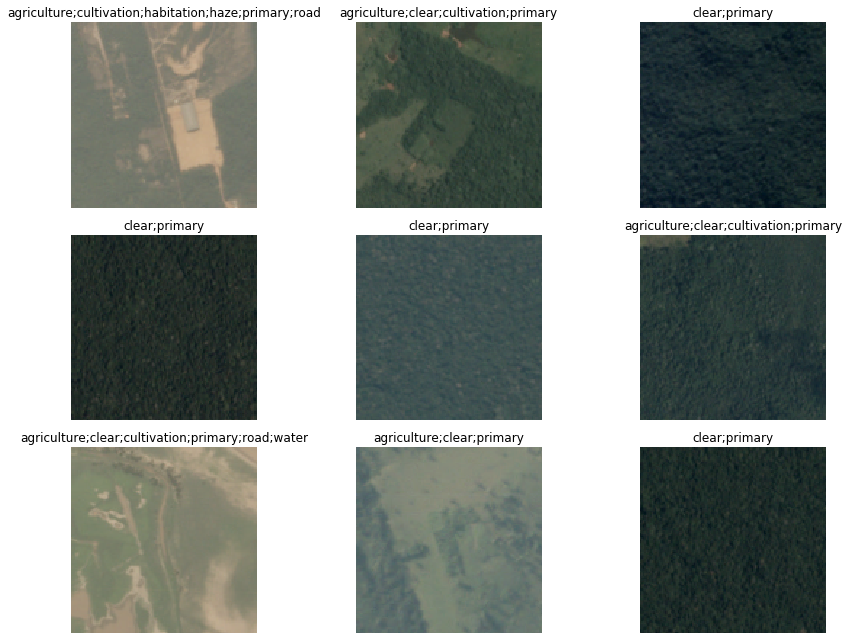

In [35]:
data.show_batch(rows=3, figsize=(12,9))

In [39]:
### train model,choose model and metrics
arch = models.resnet50

In [37]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/zhuangxuxia/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:09<00:00, 10760186.89it/s]



To create a Learner we use the same function as in lesson 1. Our base architecture is resnet50 again, 
but the metrics are a little bit differeent: we use accuracy_thresh instead of accuracy. In lesson 1,
we determined the predicition for a given class by picking the final activation that was the biggest, but here, 
each activation can be 0. or 1. accuracy_thresh selects the ones that are above a certain threshold (0.5 by default) 
and compares them to the ground truth

In [38]:
### find best learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


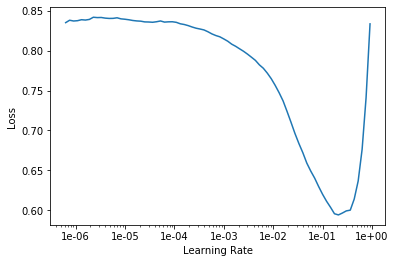

In [40]:
learn.recorder.plot()

# then we can know the better steap slope for the lr
learn.fit_one_cycle(4, slice(0.01))

In [42]:
### since it's too slow, I interrrupted the learning

In [43]:
learn.save('stage-1-rn50')

Now we need to tune our model, we need to unfreeze the data

In [44]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

since I don't have a high speed cpu, the learning is too slow, so I just review what I need to do.

from the lr plot, we can know which lr is good for us. I assume we choose le-5, the second part we use original lr divide 5.

learn.fit_one_cycle(5, slice(1e-5, lr/5))

learn.save('stage-2-rn50')

because when we train model at the begining ,the size of the image is 128, now we aare gonna change it into 256
to improve the model performance.

data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

we use some data to train a t the first stage
learn.freeze()

learn.lr_find()
learn.recorder.plot()
learn.fit_one_cycle(5, slice(lr))### to get learning rate

second stage: 
    
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/5))

learn.recorder.plot_losses() ## plot to see the loss of training data and validation data

learn.save('stage-2-256-rn50')

learn.export()